# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
# force Pandas to show all rows of features dataframe
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [4]:
azdias.head(n=5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


Dataset has 85 columns:

In [5]:
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

Data frame has 891221 entries. Several of the columns have null values.

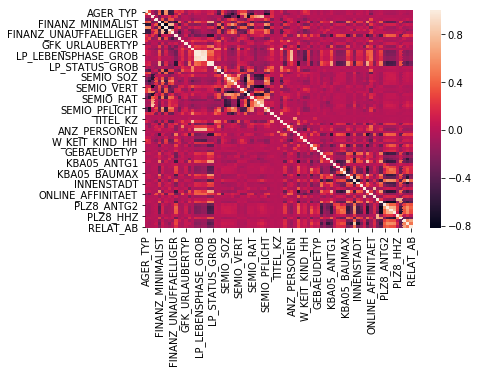

In [7]:
sns.heatmap(azdias.corr())

The heatmap shows that around half of the features are correlated. That suggests that several dimensions can be removed.

Next we read the Features Summary file.

In [8]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [9]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [10]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

The lists in column 'missing_or_unknown' were encoded as strings. They must first be converted to a list.

In [11]:
feat_info['missing_codes'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(',')).values

In [12]:
feat_info['missing_codes'][:10]

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
5          [-1]
6          [-1]
7          [-1]
8          [-1]
9          [-1]
Name: missing_codes, dtype: object

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [13]:
def set_nan(df, df_info):
    num_missing=[]

    for i in df.columns:
        a = 0
        a += df[i].isnull().sum()
        for x in feat_info[feat_info['attribute']==i]['missing_codes'].values[0]:
            try:
                a += df[df[i]==int(x)][i].count()
                df.loc[df[i]==int(x),i] = np.nan
            except:
                a += df[df[i]==x][i].count()
                df.loc[df[i]==x,i] = np.nan
        
        num_missing.append(a)

    return num_missing

In [14]:
df = azdias.copy()
num_missing = set_nan(df, feat_info)

/home/bmartins/miniconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [15]:
# sanity checking
len(num_missing)

85

In [16]:
# sanity checking
(df.iloc[:,58]=='XX').values.any()

False

In [17]:
df_feat = feat_info.copy()
df_feat['num_missing'] = num_missing

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
df_feat_mod = df_feat.drop(df_feat[df_feat['num_missing'].values == 0].index)

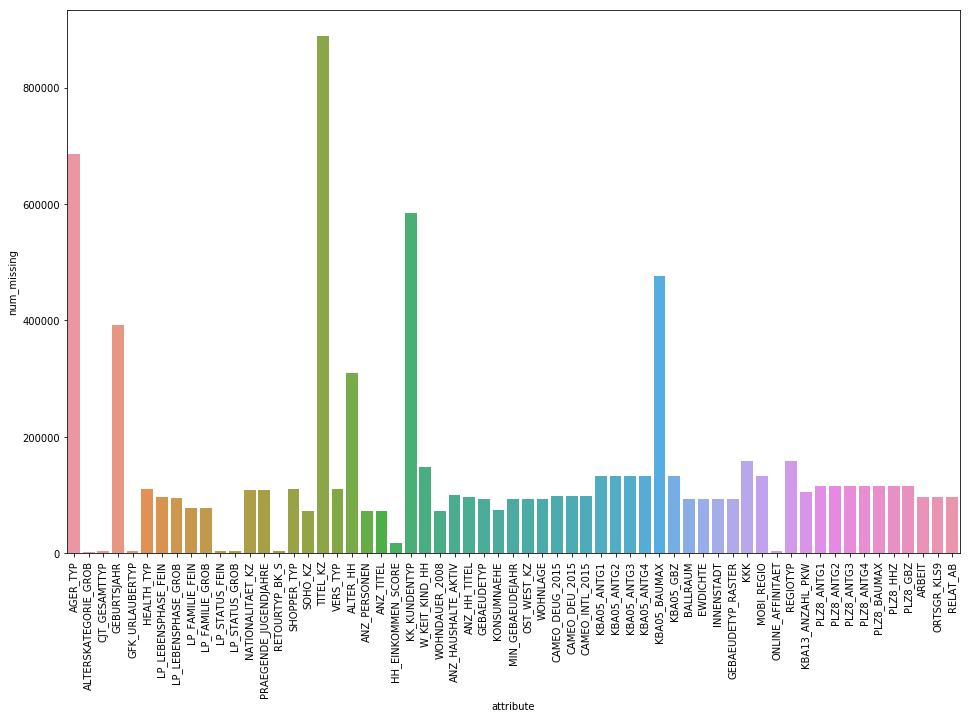

In [19]:
fig,ax = plt.subplots(figsize=(16,10))
#ax.hist(df_feat['num_missing'].values)
#ax.set_xticks(np.arange(0,7))
#ax.set_xticklabels(df_feat['attribute'], rotation=90)
ax = sns.barplot(x="attribute", y="num_missing", data=df_feat_mod)
#ax.set_xticklabels(rotation=90)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [20]:
# top 10 for missing entries
df_feat.loc[df_feat['num_missing'].nlargest(10).index.to_list(),'attribute']

40          TITEL_KZ
0           AGER_TYP
47      KK_KUNDENTYP
64      KBA05_BAUMAX
11       GEBURTSJAHR
43          ALTER_HH
70               KKK
73          REGIOTYP
48    W_KEIT_KIND_HH
60       KBA05_ANTG1
Name: attribute, dtype: object

In [21]:
list_drop = df_feat.loc[df_feat['num_missing'].nlargest(10).index.to_list(),'attribute'].to_list()

In [22]:
df.drop(list_drop, axis=1, inplace=True)

In [23]:
df_feat.shape

(85, 6)

In [24]:
df_feat.drop(df_feat[df_feat['attribute'].isin(list_drop)].index.to_list(), axis=0, inplace=True)

In [25]:
# sanity checking
df_feat.shape

(75, 6)

In [26]:
# sanity checking
df.shape

(891221, 75)

Discuss the columns that were dropped

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

_________________________

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
df['missing'] = df.isnull().sum(axis=1)

In [28]:
df['missing'].describe()

count    891221.000000
mean          4.979533
std          12.056804
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          45.000000
Name: missing, dtype: float64

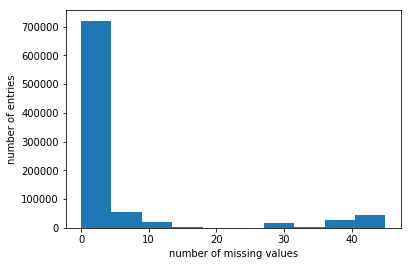

In [29]:
plt.hist(df['missing']);
plt.xlabel('number of missing values')
plt.ylabel('number of entries');

The majority of entries has no missing values. The data was divided in two subsets: below or above 20 missing points.

In [30]:
df_not_missing = df[df['missing']<=20]
df_missing = df[df['missing']>20]

In [31]:
df_not_missing.shape

(797847, 76)

In [32]:
df_missing.shape

(93374, 76)

In [33]:
df_not_missing[df_feat[df_feat['num_missing'].values == 0]['attribute'].to_list()].columns

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

In [34]:
def compare_codes(col_list, df1, df2):
    fig, ax = plt.subplots(len(col_list), 2, figsize=(14, 14), sharex=True)

    for i in range(len(col_list)):
        sns.countplot(y=col_list[i], data=df1, ax=ax[i,0])
        if (i==0): 
            ax[0,0].set_title("DF 1")
        sns.countplot(y=col_list[i], data=df2, ax=ax[i,1])
        if (i==0): 
            ax[0,1].set_title("DF 2")

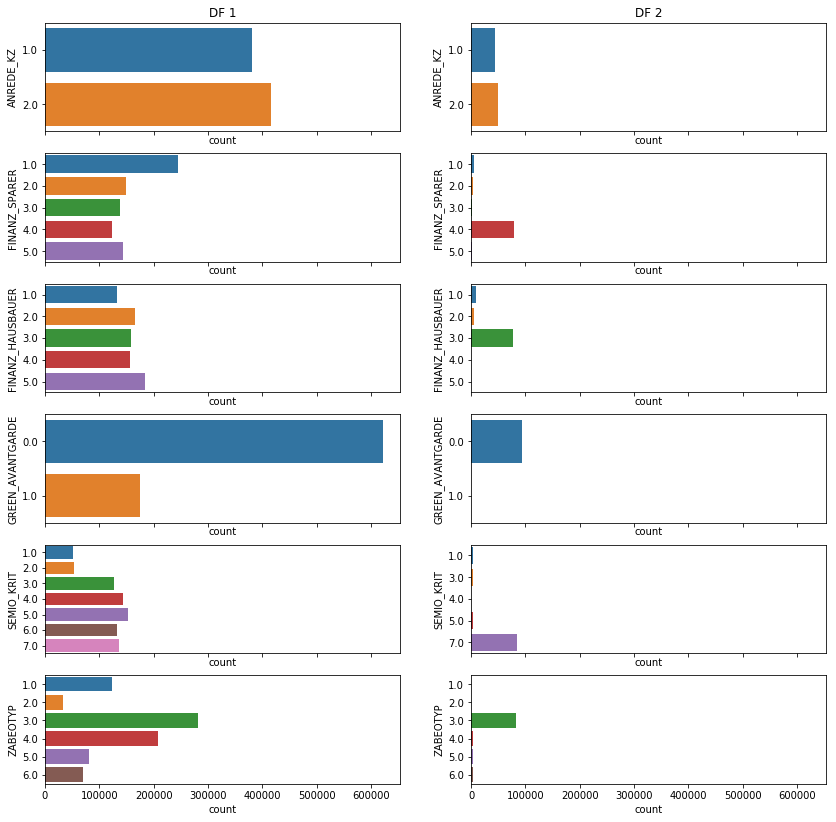

In [35]:
col_list=['ANREDE_KZ','FINANZ_SPARER','FINANZ_HAUSBAUER','GREEN_AVANTGARDE','SEMIO_KRIT','ZABEOTYP']
compare_codes(col_list, df_not_missing, df_missing)

The two subsets are clearly different in their distribution of values.

Continue analysis using df_not_missing

In [36]:
df_2 = df_not_missing.copy()

In [37]:
list_num = df_feat[df_feat['type']=='numeric']['attribute']
list_not_num = df_feat[df_feat['type']!='numeric']['attribute']

In [38]:
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_num.fit(df_2[list_num])
imputer_num.statistics_

array([1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 1.992e+03, 5.490e+02])

In [39]:
df_2[list_num] = imputer_num.transform(df_2[list_num])

In [40]:
imputer_not_num = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_not_num.fit(df_2[list_not_num])
imputer_not_num.statistics_

array([3.0, 2.0, 4.0, 3.0, 1.0, 5.0, 1.0, 1.0, 5.0, 6.0, 12.0, 0.0, 3.0,
       1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 14.0, 5.0, 2.0, 2.0, 4.0, 4.0,
       2.0, 6.0, 4.0, 5.0, 4.0, 5.0, 5.0, 3.0, 4.0, 4.0, 1.0, 0.0, 2.0,
       3.0, 6.0, 9.0, 1.0, 1.0, 'W', 3.0, '8', '6B', '51', 0.0, 0.0, 0.0,
       3.0, 6.0, 6.0, 5.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0,
       3.0, 4.0, 5.0, 3.0], dtype=object)

In [41]:
df_2[list_not_num] = imputer_not_num.transform(df_2[list_not_num])

In [42]:
#df_2['KBA13_ANZAHL_PKW'].max()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
list_cat = df_feat[df_feat['type']=='categorical']['attribute'].to_list()

In [44]:
print('There are {} categorical features'.format(len(list_cat)))

There are 18 categorical features


In [45]:
list_mixed = df_feat[df_feat['type']=='mixed']['attribute'].to_list()

In [46]:
print('There are {} mixed features'.format(len(list_mixed)))

There are 6 mixed features


In [47]:
unique_cat = {i:len(df_2[i].unique()) for i in list_cat}
unique_cat

{'ANREDE_KZ': 2,
 'CJT_GESAMTTYP': 6,
 'FINANZTYP': 6,
 'GFK_URLAUBERTYP': 12,
 'GREEN_AVANTGARDE': 2,
 'LP_FAMILIE_FEIN': 11,
 'LP_FAMILIE_GROB': 5,
 'LP_STATUS_FEIN': 10,
 'LP_STATUS_GROB': 5,
 'NATIONALITAET_KZ': 3,
 'SHOPPER_TYP': 4,
 'SOHO_KZ': 2,
 'VERS_TYP': 2,
 'ZABEOTYP': 6,
 'GEBAEUDETYP': 7,
 'OST_WEST_KZ': 2,
 'CAMEO_DEUG_2015': 9,
 'CAMEO_DEU_2015': 44}

ANREDE_KZ has two numeric levels = {1 - male, 2 - female} and GREEN_AVANTGARDE has two numeric levels = {0 - not member, 1 - member}

SOHO_KZ has two numeric levels.

OST_WEST_KZ has two categorical levels (O, W).

In [48]:
df_feat[df_feat['attribute'].isin(list_mixed)][['attribute','num_missing']]

,attribute,num_missing
15,LP_LEBENSPHASE_FEIN,97632
16,LP_LEBENSPHASE_GROB,94572
22,PRAEGENDE_JUGENDJAHRE,108164
56,WOHNLAGE,93148
59,CAMEO_INTL_2015,99352
79,PLZ8_BAUMAX,116515


In [49]:
unique_mixed = {i: len(df_2[i].unique()) for i in list_mixed}
unique_mixed

{'LP_LEBENSPHASE_FEIN': 40,
 'LP_LEBENSPHASE_GROB': 12,
 'PRAEGENDE_JUGENDJAHRE': 15,
 'WOHNLAGE': 8,
 'CAMEO_INTL_2015': 21,
 'PLZ8_BAUMAX': 5}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [50]:
# binary numeric-encoded variables - do nothing
list_binary = ['ANREDE_KZ','SOHO_KZ','GREEN_AVANTGARDE']

Doing onehot after dealing with mixed variables

In [51]:
#list_onehot = list(filter(lambda x: x not in var_binary, list_cat))

In [52]:
#list_onehot

In [53]:
#one_hot = OneHotEncoder()
#one_hot.fit(df_2[list_onehot])
#one_hot.categories_

In [54]:
#mat_onehot = one_hot.transform(df_2[list_onehot])

In [55]:
#type(mat_onehot)

In [56]:
#mat_onehot.shape

In [57]:
#df_onehot = pd.DataFrame(data = mat_onehot.todense(), columns=one_hot.get_feature_names())

In [58]:
#df_2.drop(list_onehot,axis=1, inplace=True)

In [59]:
#df_2.shape

In [60]:
#df_onehot.shape

In [61]:
#df_2.reset_index(drop=True, inplace=True)
#df_onehot.reset_index(drop=True, inplace=True)
#df_3 = pd.concat( [df_2, df_onehot], axis=1) 

In [62]:
#df_3.shape

In [63]:
#df_3.columns

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
df_feat[df_feat['type']=='mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

### Mixed variable PRAGENDE_JUGENDJAHRE

#### Categories for PRAGENDE_JUGENDJAHRE_intervall
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

#### Categories for PRAGENDE_JUGENDJAHRE_trend
- 0: mainstream
- 1: avantgarde

In [65]:
pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

In [66]:
df_2['PRAEGENDE_JUGENDJAHRE_intervall'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[int(x)])

In [67]:
pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

In [68]:
df_2['PRAEGENDE_JUGENDJAHRE_trend'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[int(x)])

In [69]:
df_2.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

### Mixed variable CAMEO_INTL_2015

#### Categories for CAMEO_INTL_2015_reichtum
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

#### Categories for CAMEO_INTL_2015_leben
- 0: mainstream
- 1: avantgarde

In [70]:
cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}

In [71]:
df_2['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [72]:
df_2['CAMEO_INTL_2015_reichtum'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cir_dict[int(x)])

In [73]:
df_2['CAMEO_INTL_2015_leben'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cil_dict[int(x)])

In [74]:
df_2.drop('CAMEO_INTL_2015', axis=1, inplace=True)

### Mixed variable LP_LEBENSPHASE_FEIN

#### Categories for LP_LEBENSPHASE_FEIN_alter

1: young age
2: middle age
3: retirement age
4: advanced age
5: higher age

LP_LEBENSPHASE_FEIN_verdiener

- 1: low-income earners 
- 2: average earner
- 3: independent
- 4: homeowner
- 5: top earner
- 6: wealthy

LP_LEBENSPHASE_FEIN_familie
- 1: single
- 2: single parent
- 3: multiperson households
- 4: families
- 5: couples

-  1: single low-income earners of younger age: 1, 1, 1
-  2: single low-income earners of middle age: 2, 1, 1
-  3: single average earners of younger age: 1, 2, 1
-  4: single average earners of middle age: 2, 2, 1
-  5: single low-income earners of advanced age: 4, 1, 1
-  6: single low-income earners at retirement age: 3, 1, 1 
-  7: single average earners of advanced age: 4, 2, 1
-  8: single average earners at retirement age: 3, 2, 1
-  9: single independent persons: 2, 3, 1
- 10: wealthy single homeowners: 6, 3, 1
- 11: single homeowners of advanced age: 4, 4, 1
- 12: single homeowners at retirement age: 3, 4, 1
- 13: single top earners of higher age: 5, 5, 1
- 14: low-income and average earner couples of younger age: 1, 2, 5  
- 15: low-income earner couples of higher age: 5, 1, 5
- 16: average earner couples of higher age: 5, 2, 5
- 17: independent couples: 2, 3, 5
- 18: wealthy homeowner couples of younger age: 1, 6, 5 
- 19: homeowner couples of higher age: 5, 4, 5
- 20: top earner couples of higher age: 5, 5, 5
- 21: single parent low-income earners: 2, 1, 2
- 22: single parent average earners: 2, 2, 2
- 23: single parent high-income earners: 2, 5, 2
- 24: low-income earner families: 2, 1, 4
- 25: average earner families: 2, 2, 4
- 26: independent families: 2, 3, 4
- 27: homeowner families: 2, 4, 4
- 28: top earner families: 2, 5, 4
- 29: low-income earners of younger age from multiperson households: 1, 1, 3
- 30: average earners of younger age from multiperson households: 1, 2, 3
- 31: low-income earners of higher age from multiperson households: 5, 1, 3
- 32: average earners of higher age from multiperson households: 5, 2, 3
- 33: independent persons of younger age from multiperson households: 1, 3, 3
- 34: homeowners of younger age from multiperson households: 1, 4, 3
- 35: top earners of younger age from multiperson households: 1, 5, 3
- 36: independent persons of higher age from multiperson households: 5, 3, 3
- 37: homeowners of advanced age from multiperson households: 4, 4, 3
- 38: homeowners at retirement age from multiperson households: 3, 4, 3
- 39: top earners of middle age from multiperson households: 2, 5, 3
- 40: top earners at retirement age from multiperson households: 3, 5, 3

llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

#### Categories for CAMEO_INTL_2015_leben
- 0: mainstream
- 1: avantgarde

In [75]:
llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

In [76]:
df_2['LP_LEBENSPHASE_FEIN_alter'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfa_dict[int(x)])

In [77]:
df_2['LP_LEBENSPHASE_FEIN_verdiener'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfv_dict[int(x)])

In [78]:
df_2['LP_LEBENSPHASE_FEIN_familie'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llff_dict[int(x)])

In [79]:
df_2.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

LP_LEBENSPHASE_GROB

LP_LEBENSPHASE_GROB_alter
1: young age
2: middle age
3: higher age

LP_LEBENSPHASE_GROB_verdiener

- 1: low-income and average earner
- 2: high-income

LP_LEBENSPHASE_GROB_familie
- 1: single
- 2: couples
- 3: families
- 4: multiperson
- 5: single parents

-  1: single low-income and average earners of younger age: 1, 1, 1
-  2: single low-income and average earners of higher age: 3, 1, 1
-  3: single high-income earners: 2, 2, 1
-  4: single low-income and average-earner couples: 2, 1, 2
-  5: single high-income earner couples: 2, 2, 2
-  6: single parents: 2, 1, 5
-  7: single low-income and average earner families: 2, 1, 3
-  8: high-income earner families: 2, 2, 3
-  9: average earners of younger age from multiperson households: 1, 1, 4
- 10: low-income and average earners of higher age from multiperson households: 3, 1, 4
- 11: high-income earners of younger age from multiperson households: 1, 2, 4
- 12: high-income earners of higher age from multiperson households: 3, 2, 4

llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
llgv_dict={1:1, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:1, 11:2, 12:2}
llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}

In [80]:
llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
llgv_dict={1:1, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:1, 11:2, 12:2}
llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}

In [81]:
df_2['LP_LEBENSPHASE_GROB_alter'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llga_dict[int(x)])

In [82]:
df_2['LP_LEBENSPHASE_GROB_verdiener'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgv_dict[int(x)])

In [83]:
df_2['LP_LEBENSPHASE_GROB_familie'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgf_dict[int(x)])

In [84]:
df_2.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

WOHNLAGE

- 1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

PLZ8_BAUMAX

PLZ8_BAUMAX_nummer

- 1: 1-2
- 2: 3-5
- 3: 6-10
- 4: 10+

PLZ8_BAUMAX_art

- 1: family home
- 2: business buildings


-  1: mainly 1-2 family homes: 1,1
-  2: mainly 3-5 family homes: 2,1
-  3: mainly 6-10 family homes: 3,1
-  4: mainly 10+ family homes: 4,1
-  5: mainly business buildings: 1,2



In [85]:
pbn_dict = {1:1, 2:2, 3:3, 4:4, 5:1}
pba_dict = {1:1, 2:1, 3:1, 4:1, 5:2}

In [86]:
df_2['PLZ8_BAUMAX_nummer'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pbn_dict[int(x)])

In [87]:
df_2['PLZ8_BAUMAX_art'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pba_dict[int(x)])

In [88]:
df_2.drop('PLZ8_BAUMAX', axis=1, inplace=True)

### One hot encode

In [89]:
list_mixed_new = ['PRAEGENDE_JUGENDJAHRE_intervall','PRAEGENDE_JUGENDJAHRE_trend',
                  'CAMEO_INTL_2015_reichtum','CAMEO_INTL_2015_leben','LP_LEBENSPHASE_FEIN_alter',
                  'LP_LEBENSPHASE_FEIN_verdiener','LP_LEBENSPHASE_FEIN_familie','LP_LEBENSPHASE_GROB_alter',
                  'LP_LEBENSPHASE_GROB_verdiener','LP_LEBENSPHASE_GROB_familie','WOHNLAGE','PLZ8_BAUMAX_nummer',
                  'PLZ8_BAUMAX_art']
list_cat = list_cat + list_mixed_new
list_onehot = list(filter(lambda x: x not in list_binary, list_cat))

In [90]:
list_onehot

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'PRAEGENDE_JUGENDJAHRE_intervall',
 'PRAEGENDE_JUGENDJAHRE_trend',
 'CAMEO_INTL_2015_reichtum',
 'CAMEO_INTL_2015_leben',
 'LP_LEBENSPHASE_FEIN_alter',
 'LP_LEBENSPHASE_FEIN_verdiener',
 'LP_LEBENSPHASE_FEIN_familie',
 'LP_LEBENSPHASE_GROB_alter',
 'LP_LEBENSPHASE_GROB_verdiener',
 'LP_LEBENSPHASE_GROB_familie',
 'WOHNLAGE',
 'PLZ8_BAUMAX_nummer',
 'PLZ8_BAUMAX_art']

In [91]:
one_hot = OneHotEncoder()
one_hot.fit(df_2[list_onehot])
one_hot.categories_

[array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0],
       dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0],
       dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=object),
 array([1.0, 2.0, 3.0], dtype=object),
 array([0.0, 1.0, 2.0, 3.0], dtype=object),
 array([1.0, 2.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0], dtype=object),
 array(['O', 'W'], dtype=object),
 array(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array(['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B',
        '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D',
        '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', 

In [92]:
mat_onehot = one_hot.transform(df_2[list_onehot])

In [93]:
df_onehot = pd.DataFrame(data = mat_onehot.todense(), columns=one_hot.get_feature_names())

In [94]:
list_after_onehot = df_onehot.columns.to_list()

In [95]:
df_2.drop(list_onehot,axis=1, inplace=True)

In [96]:
df_2.reset_index(drop=True, inplace=True)
df_onehot.reset_index(drop=True, inplace=True)

df_3 = pd.concat( [df_2, df_onehot], axis=1) 

In [97]:
df_3.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing,x0_1.0,x0_2.0,x0_3.0,x0_4.0,x0_5.0,x0_6.0,x1_1.0,x1_2.0,x1_3.0,x1_4.0,x1_5.0,x1_6.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0,x2_5.0,x2_6.0,x2_7.0,x2_8.0,x2_9.0,x2_10.0,x2_11.0,x2_12.0,x3_1.0,x3_2.0,x3_3.0,x3_4.0,x3_5.0,x3_6.0,x3_7.0,x3_8.0,x3_9.0,x3_10.0,x3_11.0,x4_1.0,x4_2.0,x4_3.0,x4_4.0,x4_5.0,x5_1.0,x5_2.0,x5_3.0,x5_4.0,x5_5.0,x5_6.0,x5_7.0,x5_8.0,x5_9.0,x5_10.0,x6_1.0,x6_2.0,x6_3.0,x6_4.0,x6_5.0,x7_1.0,x7_2.0,x7_3.0,x8_0.0,x8_1.0,x8_2.0,x8_3.0,x9_1.0,x9_2.0,x10_1.0,x10_2.0,x10_3.0,x10_4.0,x10_5.0,x10_6.0,x11_1.0,x11_2.0,x11_3.0,x11_4.0,x11_5.0,x11_6.0,x11_8.0,x12_O,x12_W,x13_1,x13_2,x13_3,x13_4,x13_5,x13_6,x13_7,x13_8,x13_9,x14_1A,x14_1B,x14_1C,x14_1D,x14_1E,x14_2A,x14_2B,x14_2C,x14_2D,x14_3A,x14_3B,x14_3C,x14_3D,x14_4A,x14_4B,x14_4C,x14_4D,x14_4E,x14_5A,x14_5B,x14_5C,x14_5D,x14_5E,x14_5F,x14_6A,x14_6B,x14_6C,x14_6D,x14_6E,x14_6F,x14_7A,x14_7B,x14_7C,x14_7D,x14_7E,x14_8A,x14_8B,x14_8C,x14_8D,x14_9A,x14_9B,x14_9C,x14_9D,x14_9E,x15_1,x15_2,x15_3,x15_4,x15_5,x15_6,x16_0,x16_1,x17_1,x17_2,x17_3,x17_4,x17_5,x18_1,x18_2,x18_3,x18_4,x18_5,x19_1,x19_2,x19_3,x19_4,x19_5,x19_6,x20_1,x20_2,x20_3,x20_4,x20_5,x20_6,x21_1,x21_2,x21_3,x21_4,x21_5,x22_1,x22_2,x22_3,x23_1,x23_2,x24_1,x24_2,x24_3,x24_4,x24_5,x25_0.0,x25_1.0,x25_2.0,x25_3.0,x25_4.0,x25_5.0,x25_7.0,x25_8.0,x26_1,x26_2,x26_3,x26_4,x27_1,x27_2
count,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.00000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.000000,797847.0000

In [98]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797847 entries, 0 to 797846
Columns: 246 entries, ALTERSKATEGORIE_GROB to x27_2
dtypes: float64(245), int64(1)
memory usage: 1.5 GB


In [99]:
df_3['KBA13_ANZAHL_PKW'].max()

2300.0

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In [100]:
df_3.shape

(797847, 246)

In [101]:
df_3.isnull().values.any()

False

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [102]:
df_3.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797847 entries, 0 to 797846
Data columns (total 246 columns):
ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                float64
FINANZ_MINIMALIST        float64
FINANZ_SPARER            float64
FINANZ_VORSORGER         float64
FINANZ_ANLEGER           float64
FINANZ_UNAUFFAELLIGER    float64
FINANZ_HAUSBAUER         float64
GREEN_AVANTGARDE         float64
HEALTH_TYP               float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                float64
SEMIO_FAM                float64
SEMIO_REL                float64
SEMIO_MAT                float64
SEMIO_VERT               float64
SEMIO_LUST               float64
SEMIO_ERL                float64
SEMIO_KULT               float64
SEMIO_RAT                float64
SEMIO_KRIT               float64
SEMIO_DOM                float64
SEMIO_KAEM               float64
SEMIO_PFLICHT            float64
SEMIO_TRADV              float64
SOHO_KZ                  float64
ANZ_PERSONEN             float

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [103]:
def clean_data(df, df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    num_missing = set_nan(df, df_info)
    
    # remove selected columns and rows, ...
    list_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 
                 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 
                 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1']

    df.drop(list_drop, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    df['missing'] = df.isnull().sum(axis=1)
    df_not_missing = df[df['missing']<=20]
    df_2 = df_not_missing.copy()
    
    list_num = df_feat[df_feat['type']=='numeric']['attribute']
    list_not_num = df_feat[df_feat['type']!='numeric']['attribute']
    
    imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer_num.fit(df_2[list_num])
    df_2[list_num] = imputer_num.transform(df_2[list_num])
    
    imputer_not_num = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer_not_num.fit(df_2[list_not_num])
    df_2[list_not_num] = imputer_not_num.transform(df_2[list_not_num])
   
    
    pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df_2['PRAEGENDE_JUGENDJAHRE_intervall'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[x])
    df_2['PRAEGENDE_JUGENDJAHRE_trend'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[x])
    df_2.drop('PRAEGENDE_JUGENDJAHRE', inplace=True)
    
    cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df_2['CAMEO_INTL_2015_reichtum'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cir_dict[int(x)])
    df_2['CAMEO_INTL_2015_leben'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cil_dict[int(x)])
    df_2.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

    llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

    llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}
    df_2['LP_LEBENSPHASE_FEIN_alter'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfa_dict[int(x)])
    df_2['LP_LEBENSPHASE_FEIN_verdiener'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfv_dict[int(x)])
    df_2['LP_LEBENSPHASE_FEIN_familie'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llff_dict[int(x)])
    df_2.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
    llgv_dict={1:1, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:1, 11:2, 12:2}
    llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}
    df_2['LP_LEBENSPHASE_GROB_alter'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llga_dict[int(x)])
    df_2['LP_LEBENSPHASE_GROB_verdiener'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgv_dict[int(x)])
    df_2['LP_LEBENSPHASE_GROB_familie'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgf_dict[int(x)])
    df_2.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    pbn_dict = {1:1, 2:2, 3:3, 4:4, 5:1}
    pba_dict = {1:1, 2:1, 3:1, 4:1, 5:2}
    df_2['PLZ8_BAUMAX_nummer'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pbn_dict[int(x)])
    df_2['PLZ8_BAUMAX_art'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pba_dict[int(x)])
    df_2.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    
    one_hot = OneHotEncoder()
    one_hot.fit(df_2[list_onehot])
    mat_onehot = one_hot.transform(df_2[list_onehot])
    df_onehot.reset_index(drop=True, inplace=True)
    df_2.drop(list_onehot,axis=1, inplace=True)
    df_2.reset_index(drop=True, inplace=True)
    df_onehot.reset_index(drop=True, inplace=True)
    df_3 = pd.concat( [df_2, df_onehot], axis=1) 
    
    
    # Return the cleaned dataframe.
    
    return df_3
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [104]:
list_scaled = list(filter(lambda x: x not in list_after_onehot, df_3.columns.to_list()))

In [105]:
list_scaled

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'missing']

In [106]:
df_scaled = df_3.copy()

In [107]:
scaler = StandardScaler()
df_scaled[list_scaled] = scaler.fit_transform(df_scaled[list_scaled])

/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [108]:
df_scaled['x14_8B'].unique()

array([0., 1.])

In [109]:
df_scaled.shape

(797847, 246)

(array([ 55671., 231814., 253169., 129734.,  66322.,  24366.,  26143.,
          6411.,   2648.,   1569.]),
 array([-1.83300095, -1.15146309, -0.46992524,  0.21161261,  0.89315046,
         1.57468831,  2.25622616,  2.93776401,  3.61930186,  4.30083971,
         4.98237756]),
 <a list of 10 Patch objects>)

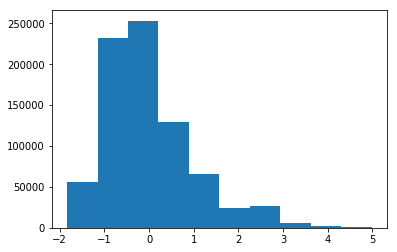

In [111]:
plt.hist(df_scaled['KBA13_ANZAHL_PKW'])

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)m

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [112]:
pca_model = PCA()
X_pca = pca_model.fit_transform(df_scaled)

In [113]:
X_pca.shape

(797847, 246)

In [114]:
pca_model.explained_variance_ratio_

array([1.45408202e-01, 1.16344014e-01, 8.29262125e-02, 4.21396067e-02,
       3.23373420e-02, 2.89562403e-02, 2.79369953e-02, 2.36406066e-02,
       2.01777806e-02, 1.89004351e-02, 1.75320817e-02, 1.65941815e-02,
       1.61466227e-02, 1.43478916e-02, 1.40178806e-02, 1.36536330e-02,
       1.26171425e-02, 1.16717820e-02, 1.14540426e-02, 1.12654381e-02,
       1.07372365e-02, 1.05946305e-02, 9.59783887e-03, 9.09008490e-03,
       8.35674900e-03, 7.56047777e-03, 7.18392731e-03, 6.89417079e-03,
       6.63773567e-03, 6.52085136e-03, 6.28711330e-03, 5.98677235e-03,
       5.81793261e-03, 5.66169725e-03, 5.55016259e-03, 5.44386527e-03,
       5.22207919e-03, 5.08909859e-03, 4.96678461e-03, 4.80201304e-03,
       4.68887304e-03, 4.47958776e-03, 4.38820104e-03, 4.13484524e-03,
       4.02126457e-03, 3.88414634e-03, 3.74131291e-03, 3.73495090e-03,
       3.64094473e-03, 3.54739363e-03, 3.48418103e-03, 3.38490003e-03,
       3.21085503e-03, 3.12872335e-03, 3.06129423e-03, 3.00612466e-03,
      

In [116]:
pca_model.explained_variance_ratio_[:10].sum()

0.5387674358235027

In [117]:
components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df_scaled.keys())

In [ ]:
ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)

In [ ]:
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca_model.components_)+1)]

In [ ]:
components.index = dimensions

In [ ]:
ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)

In [ ]:
variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])

In [ ]:
variance_ratios.index = dimensions

In [ ]:
concat = pd.concat([variance_ratios, components], axis=1)
concat

In [121]:
components

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing,x0_1.0,x0_2.0,x0_3.0,x0_4.0,x0_5.0,x0_6.0,x1_1.0,x1_2.0,x1_3.0,x1_4.0,x1_5.0,x1_6.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0,x2_5.0,x2_6.0,x2_7.0,x2_8.0,x2_9.0,x2_10.0,x2_11.0,x2_12.0,x3_1.0,x3_2.0,x3_3.0,x3_4.0,x3_5.0,x3_6.0,x3_7.0,x3_8.0,x3_9.0,x3_10.0,x3_11.0,x4_1.0,x4_2.0,x4_3.0,x4_4.0,x4_5.0,x5_1.0,x5_2.0,x5_3.0,x5_4.0,x5_5.0,x5_6.0,x5_7.0,x5_8.0,x5_9.0,x5_10.0,x6_1.0,x6_2.0,x6_3.0,x6_4.0,x6_5.0,x7_1.0,x7_2.0,x7_3.0,x8_0.0,x8_1.0,x8_2.0,x8_3.0,x9_1.0,x9_2.0,x10_1.0,x10_2.0,x10_3.0,x10_4.0,x10_5.0,x10_6.0,x11_1.0,x11_2.0,x11_3.0,x11_4.0,x11_5.0,x11_6.0,x11_8.0,x12_O,x12_W,x13_1,x13_2,x13_3,x13_4,x13_5,x13_6,x13_7,x13_8,x13_9,x14_1A,x14_1B,x14_1C,x14_1D,x14_1E,x14_2A,x14_2B,x14_2C,x14_2D,x14_3A,x14_3B,x14_3C,x14_3D,x14_4A,x14_4B,x14_4C,x14_4D,x14_4E,x14_5A,x14_5B,x14_5C,x14_5D,x14_5E,x14_5F,x14_6A,x14_6B,x14_6C,x14_6D,x14_6E,x14_6F,x14_7A,x14_7B,x14_7C,x14_7D,x14_7E,x14_8A,x14_8B,x14_8C,x14_8D,x14_9A,x14_9B,x14_9C,x14_9D,x14_9E,x15_1,x15_2,x15_3,x15_4,x15_5,x15_6,x16_0,x16_1,x17_1,x17_2,x17_3,x17_4,x17_5,x18_1,x18_2,x18_3,x18_4,x18_5,x19_1,x19_2,x19_3,x19_4,x19_5,x19_6,x20_1,x20_2,x20_3,x20_4,x20_5,x20_6,x21_1,x21_2,x21_3,x21_4,x21_5,x22_1,x22_2,x22_3,x23_1,x23_2,x24_1,x24_2,x24_3,x24_4,x24_5,x25_0.0,x25_1.0,x25_2.0,x25_3.0,x25_4.0,x25_5.0,x25_7.0,x25_8.0,x26_1,x26_2,x26_3,x26_4,x27_1,x27_2
0,-0.1313,0.0121,-0.2299,0.1583,-0.1238,0.0765,0.0887,0.1629,-0.0986,0.0416,-0.0251,0.0421,0.0799,0.1217,0.0835,-0.0452,-0.0785,-0.0822,0.0743,0.1053,0.0056,0.0296,0.0426,0.1254,0.0999,-0.0021,-0.0842,-0.0039,0.1966,-0.0640,0.1347,0.0349,-0.1688,-0.0516,0.0153,0.1321,0.1509,-0.2103,-0.1310,0.1989,-0.1671,-0.1183,-0.2156,-0.0404,-0.0748,-0.2200,0.1532,0.2222,0.2144,0.0453,-0.1613,0.1397,0.2006,0.1343,0.0050,-0.0086,-0.0237,0.0094,0.0112,0.0043,0.0074,0.0615,-0.0339,-0.0107,0.0051,0.0015,-0.0234,-0.0045,-0.0036,-0.0036,0.0026,-0.0087,-0.0059,-0.0107,0.0017,0.0012,-0.0004,0.0084,0.0235,0.0440,-0.0122,0.0006,0.0009,0.0000,-0.0002,-0.0020,-0.0042,-0.0003,-0.0156,-0.0111,0.0440,-0.0122,0.0015,-0.0063,-0.0271,0.0584,0.0490,0.0053,-0.0093,-0.0017,-0.0054,-0.0013,-0.0033,-0.0510,-0.0405,0.1074,-0.0057,-0.0068,-0.0544,-0.0405,-0.0213,0.0149,0.0064,-0.0062,0.0090,0.0150,-0.0178,-0.0161,0.0161,-0.0339,-0.0091,-0.0185,0.0220,0.0284,0.0112,-0.0489,-0.0014,0.0318,-0.0002,0.0000,-0.0001,0.0187,0.0191,-0.0191,-0.0090,-0.0274,-0.0219,-0.0271,-0.0025,-0.0003,0.0100,0.0362,0.0420,-0.0018,-0.0008,-0.0007,-0.0045,-0.0011,-0.0049,-0.0055,-0.0074,-0.0096,-0.0031,-0.0029,-0.0074,-0.0086,-0.0105,-0.0025,-0.0118,-0.0014,-0.0009,0.0003,-0.0021,-0.0019,0.0017,-0.0001,-0.0005,0.0006,-0.0039,0.0002,0.0001,0.0018,0.0002,0.0022,0.0049,0.0018,0.0010,0.0001,0.0168,0.0095,0.0067,0.0038,0.0063,0.0115,0.0113,0.0115,0.0015,-0.0042,-0.0132,-0.0227,-0.0150,0.0039,0.0512,0.0408,-0.0408,-0.0364,-0.0490,-0.0017,0.0155,0.0715,0.0679,-0.0112,-0.0209,-0.0279,-0.0079,0.0428,0.0057,-0.0181,-0.0016,-0.0252,-0.0037,0.1007,-0.0013,-0.0105,-0.0481,-0.0393,-0.0015,0.0455,0.0015,-0.0278,-0.0063,-0.0129,0.0509,-0.0474,-0.0035,0.0971,-0.0971,0.0448,-0.0122,-0.0063,-0.0278,0.0015,-0.0009,-0.0041,-0.0020,0.0203,0.0293,0.0178,-0.0542,-0.0062,-0.0543,0.0125,0.0172,0.0245,-0.0448,0.0448
1,0.2519,0.1043,0.0519,-0.2247,0.2222,-0.1962,-0.2202,0.1199,-0.0174,-0.0524,0.1597,-0.1102,-0.1912,-0.2549,-0.1623,-0.0840,0.1755,0.2343,-0.2258,

In [119]:
components.loc[0,:].nlargest(10)

PLZ8_ANTG3            0.2222
PLZ8_ANTG4            0.2144
ORTSGR_KLS9           0.2006
EWDICHTE              0.1989
HH_EINKOMMEN_SCORE    0.1966
FINANZ_HAUSBAUER      0.1629
FINANZ_SPARER         0.1583
PLZ8_ANTG2            0.1532
KBA05_ANTG4           0.1509
ARBEIT                0.1397
Name: 0, dtype: float64

In [123]:
evr = []
for i in range(10,100):
    pca_model = PCA(n_components=i)
    X_pca = pca_model.fit_transform(df_scaled)
    evr_tmp = pca_model.explained_variance_ratio_.sum()
    evr.append(evr_tmp)
    print('components {}: {}'.format(i,evr_tmp))

ncomp = np.arange(10,100)

components 10: 0.5387659877393155
components 11: 0.5562862342112708
components 12: 0.5728916164552502
components 13: 0.5890224804570693
components 14: 0.603381557630248
components 15: 0.6174032903174684
components 16: 0.6310548128089158
components 17: 0.643674819506777
components 18: 0.6553435981101422
components 19: 0.6668011286105645
components 20: 0.6780661068243652
components 21: 0.688802371768963
components 22: 0.6993983331914915
components 23: 0.708991142975054
components 24: 0.7180791834333429
components 25: 0.7261992229071652
components 26: 0.7337504564483133
components 27: 0.7409568550735253
components 28: 0.7478463676421062
components 29: 0.7544016833486675
components 30: 0.7610343058008997
components 31: 0.7672393796990811
components 32: 0.7731431034656279
components 33: 0.7788365068759372
components 34: 0.7844897378383946
components 35: 0.7899992874398235
components 36: 0.795479168826126
components 37: 0.8009546495340633
components 38: 0.8059845289835148
components 39: 0.81

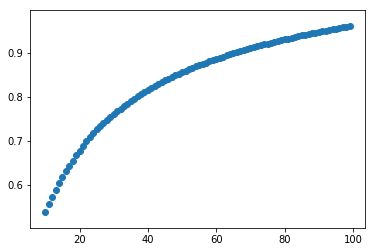

In [124]:
plt.scatter(ncomp, evr)

In [125]:
pca_model = PCA(n_components=66)
X_pca = pca_model.fit_transform(df_scaled)

In [126]:
components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df_scaled.keys())

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Numerical pipeline

In [ ]:
# apply imputer to numeric features substituting NaN by median
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_num.fit(df[list_num])
imputer_num.statistics_

In [ ]:
df[list_num] = imputer_num.transform(df[list_num])

In [ ]:
df.loc[:10,list_num]

In [ ]:
# apply min max scaler to numeric features
scaler = MinMaxScaler()
df[list_num] = scaler.fit_transform(df[list_num])

In [ ]:
# sanity checking
df.loc[:10,list_num]

This ends the numeric pipeline.

## Categorical pipeline

In [ ]:
# apply imputer to numeric features substituting NaN by median
imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_cat.fit(df[list_cat])
imputer_cat.statistics_

In [ ]:
df[list_cat] = imputer_cat.transform(df[list_cat])

In [ ]:
df.loc[:10,list_cat]

In [ ]:
# sanity checking
df.isnull().values.any()

In [ ]:
# apply one hot encoder
one_hot = OneHotEncoder()
one_hot.fit(df[list_cat])
one_hot.categories_

In [ ]:
len(one_hot.categories_)

In [ ]:
df_onehot = one_hot.transform(df[list_cat])

In [ ]:
type(df_onehot)

In [ ]:
df_onehot.shape

In [ ]:
df.drop(list_cat,axis=1).shape

In [ ]:
df_final = pd.concat([df.drop(list_cat, axis=1),
          pd.SparseDataFrame(data=df_onehot, columns=one_hot.get_feature_names())], axis=1).reindex()

In [ ]:
df_final.shape

In [ ]:
df_final.columns

This ends the preprocessing phase.